# Notebook to format data from "Integrative Framework for Long-Term Activity Monitoring of Small and Secretive Animals: Validation With a Cryptic Pitviper", DeSantis et al. (2020).

Paper can be found [here](https://www.frontiersin.org/articles/10.3389/fevo.2020.00169/full).

Data was shared over email

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import datetime
import tqdm

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/desantis_rattlesnakes'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/desantis_rattlesnakes'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
data_fp = os.path.join(raw_data_dir, 'CRAT_ACT_TrainingDataset_2016-2018IMRS.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 1
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'desantis_rattlesnakes'

In [6]:
# Load data
data = pd.read_csv(data_fp)

"Note that there are two tagIDs included but not reflected in the paper (RT-ACT13 and 14), because the logger batteries failed almost immediately after deployment (design/waterproofing flaw), but the initial releases were still captured for inclusion in the validation dataset. Additionally, RT-ACT12 is not included in the validation dataset because the individual was not on the surface during any validation observations within the brief monitoring window, and the video of the release was lost. " -Dominic DeSantis


In [7]:
data['TagID'].value_counts()

RT-ACT9     34261
RT-ACT11    25207
RT-ACT5     12356
RT-ACT2     10451
RT-ACT7      6744
RT-ACT4      5984
RT-ACT6      4746
RT-ACT1      4478
RT-ACT8      3962
RT-ACT13     2836
RT-ACT10     1612
RT-ACT3       766
RT-ACT14      607
Name: TagID, dtype: int64

In [8]:
# Interpret date and time

data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], infer_datetime_format=True)

In [9]:
# Extract integer labels for individuals

individuals = sorted(data['TagID'].unique())
def individuals_to_int(string):
    return int(string.split('-')[1][3:])

data['individual'] = data['TagID'].map(individuals_to_int)

individuals = sorted(data['individual'].unique())

In [10]:
# Split into clips
# Keep track of which individual is associated to which clip_id
# This is written very inefficiently, but it's fine for this small dataset

data['clip_id'] = 0

current_clip_id = 0
clip_ids = []

clip_id_to_individual_id = {}

clip_id_to_individual_id['clip_0'] = int(data.loc[0, 'individual'])
for index in tqdm.tqdm(data.index[:-1]):

    data.loc[index, 'clip_id'] = current_clip_id
    if data.loc[index+1, 'individual'] != data.loc[index, 'individual']:
        current_clip_id += 1
        clip_id_to_individual_id['clip_' + str(current_clip_id)] = int(data.loc[index+1, 'individual'])
    elif (data.loc[index+1, 'DateTime'] - data.loc[index, 'DateTime']).total_seconds() != 1.0:
        current_clip_id += 1
        clip_id_to_individual_id['clip_' + str(current_clip_id)] = int(data.loc[index+1, 'individual'])

data.loc[index + 1, 'clip_id'] = current_clip_id
data['clip_id'] = data['clip_id'].map(lambda x : 'clip_' + str(x))

100%|██████████| 114009/114009 [01:11<00:00, 1593.96it/s]


In [11]:
# Omit short clips (fewer than 120 seconds)
# Recreate list of individuals, just in case any were dropped in this process

long_clips = list(data['clip_id'].value_counts()[data['clip_id'].value_counts() >= 120].keys())
data = data[data['clip_id'].isin(long_clips)].copy()

individuals = sorted(data['individual'].unique())
clip_ids = sorted(data['clip_id'].unique())

In [12]:
## Codify integer codes for individuals

dataset_metadata['individual_ids'] = [int(x) for x in individuals]
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [13]:
# Set up data splits by individual

test_proportion = .34
val_proportion = .2
num_individuals = len(individuals)

test_num_individuals = int(test_proportion * num_individuals)
val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(607)
test_individuals = list(rng.choice(individuals, size = test_num_individuals, replace = False))
test_individuals.sort()

dev_individuals = individuals.copy()
for i in test_individuals:
    dev_individuals.remove(i)
    
val_individuals = list(rng.choice(dev_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()
    
train_individuals = dev_individuals.copy()
for i in val_individuals:
    train_individuals.remove(i)
    
print(train_individuals)
print(val_individuals)
print(dev_individuals)
print(test_individuals)

[2, 3, 4, 5, 6, 11, 13]
[1, 7]
[1, 2, 3, 4, 5, 6, 7, 11, 13]
[8, 9, 10, 14]


In [14]:
# Set up clip ids by split

test_clip_ids = []
train_clip_ids = []
val_clip_ids = []
dev_clip_ids = []
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
train_clip_ids.sort()
val_clip_ids.sort()
dev_clip_ids.sort()
test_clip_ids.sort()
    
dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

## Create dataset-level metadata

In [15]:
data['Behavior'].unique()

array(['Moving', 'Not Moving', 'Moving ', 'Not moving', 'Not Moving '],
      dtype=object)

In [16]:
# Clean up label names

obs_beh_to_beh_name = {
    'Moving' : 'Moving',
    'Not Moving' : 'Not_Moving',
    'Moving ' : 'Moving',
    'Not moving' : 'Not_Moving',
    'Not Moving ' : 'Not_Moving'
}

In [17]:
## Integer codes for behaviors

beh_names = sorted(set([obs_beh_to_beh_name[k] for k in obs_beh_to_beh_name]))
#beh_names.remove('unknown')
beh_names.insert(0, 'unknown')

print(beh_names)

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

data['Behavior'] = data['Behavior'].map(lambda x : obs_beh_to_beh_name[x])
data['beh_label'] = data['Behavior'].map(lambda x : beh_str_to_int[x])

['unknown', 'Moving', 'Not_Moving']


In [18]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [19]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

In [20]:
total_dur_sec = len(data) / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total duration is 111576.000000 seconds, i.e. 30.993333 hours


## Format Clip Data

In [21]:
# Save off individual clips in csv files

data['beh_int_label'] = 0

for clip_id in tqdm.tqdm(clip_ids):
    data_sub = data[data['clip_id'] == clip_id].copy()

    features = np.array(data_sub[['X', 'Ydyn', 'Z']]) #data has already been preprocessed
    clip_dur_samples = np.shape(features)[0]

    per_frame_annotations = np.array(data_sub[['individual', 'beh_label']])

    clip_data = np.concatenate([features, per_frame_annotations], axis = 1)

    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",")

100%|██████████| 149/149 [00:01<00:00, 83.57it/s]


## Check it all looks ok

In [22]:
clip_id = clip_ids[12]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')
#data = np.load(clip_data_fp)

In [23]:
np.shape(data)

(379, 5)

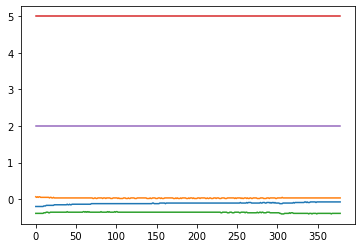

In [24]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:, i])

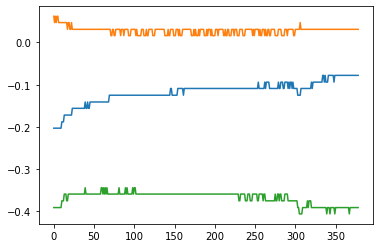

In [25]:
plt.plot(data[:, :3])

## Plot Dataset Summary

In [26]:
# Count class representation

beh_names = dataset_metadata['label_names']
train_label_count = {name : 0 for name in beh_names}
val_label_count = {name : 0 for name in beh_names}
dev_label_count = {name : 0 for name in beh_names}
test_label_count = {name : 0 for name in beh_names}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        if clip_id in dataset_metadata['train_clip_ids']:
            train_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['val_clip_ids']:
            val_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['test_clip_ids']:
            test_label_count[name] += counts[key]

train_label_perc = {name : 0 for name in beh_names[1:]}
val_label_perc = {name : 0 for name in beh_names[1:]}
dev_label_perc = {name : 0 for name in beh_names[1:]}
test_label_perc = {name : 0 for name in beh_names[1:]}

for name in beh_names[1:]:
    train_label_perc[name] = float(train_label_count[name] / sum([train_label_count[j] for j in beh_names[1:]]))
    val_label_perc[name] = float(val_label_count[name] / sum([val_label_count[j] for j in beh_names[1:]]))
    dev_label_perc[name] = float(dev_label_count[name] / sum([dev_label_count[j] for j in beh_names[1:]]))
    test_label_perc[name] = float(test_label_count[name] / sum([test_label_count[j] for j in beh_names[1:]]))

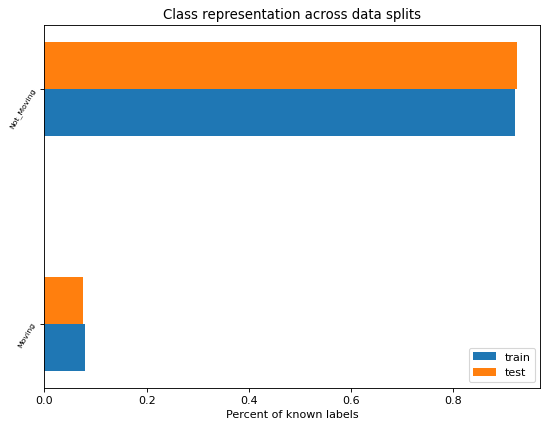

In [27]:
# Plot class representation

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.2
plt.figure(figsize=(8, 6), dpi=80)

plt.barh(keys - offset, [dev_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'train') #We call dev set 'train' in the paper
#plt.barh(keys, [val_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'val')
plt.barh(keys + offset, [test_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'test')
plt.title("Class representation across data splits")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
class_rep_dict = {'train_label_perc' : train_label_perc,
                  'val_label_perc' : val_label_perc,
                  'dev_label_perc' : dev_label_perc,
                  'test_label_perc' : test_label_perc}
with open(numerical_target_fp, 'w') as file:
    yaml.dump(class_rep_dict, file)

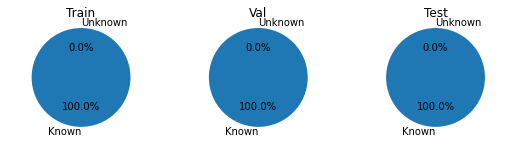

In [28]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,3, figsize = (9,2))
plt.title("blah")

ax[0].pie(train_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Train')

ax[1].pie(val_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Val')

ax[2].pie(test_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Test')

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()


## Temporal Statistics

In [5]:
####################################
infill_max_dur_sec = 0 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if list_of_labels[-1] == unknown_value:
        del list_of_labels[-1]
        del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 149/149 [00:00<00:00, 481.67it/s]

Mean overall label duration is 710.675 seconds
Re-saving metadata to /home/jupyter/behavior_data_local/data/formatted/desantis_rattlesnakes/dataset_metadata.yaml


In [7]:
# Save off summary stats

summary_fp = '/home/jupyter/BEBE-datasets/summaries.yaml'
summary_dict = {}
summary_dict['overall_durs_sec'] = overall_durs_sec

if not os.path.exists(summary_fp):
    with open(summary_fp, 'w') as file:
        yaml.dump({}, file)
        
with open(summary_fp, 'r') as file:
    summaries = yaml.safe_load(file)
    
summaries['Rattlesnakes'] = summary_dict

with open(summary_fp, 'w') as file:
    yaml.dump(summaries, file)
